In [1]:
import numpy as np
import sys
sys.path.append('../')
from src.Mondrian_matrix_utils import simulate, simulate_best
import pickle
import matplotlib.pyplot as plt
from scipy.stats import special_ortho_group

def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.0001):
    res = np.matmul(x, rotation)
    y = res[:, 0]**4 + res[:, 1]**4 + res[:, 2]**4 + res[:, 3]**4 + res[:, 4]**4
    r_noise = np.random.RandomState(seed)
    n = len(x)
    noise = r_noise.randn(n, 1) * np.sqrt(noise_sig2)
    y = y + noise[:, 0]
    return y

In [2]:
n = 5000
dim_in = 25
#rotation = pickle.load(open("rotation.pk", "rb"))
rotation = special_ortho_group.rvs(25)
#print(rotation)
x_train = np.random.rand(n,dim_in)*2 - 1
y_train = simulate_y(x_train, rotation)

x_test = np.random.rand(5000,dim_in)*2 - 1
y_test = simulate_y(x_test, rotation)

sample_range = [100, 1000, 2500, 5000, 7500, 10000, 15000, 20000]

M = 100                      # number of Mondrian trees to use
lifetime_max = 0.1          # terminal lifetime
weights_lifetime = 2*1e-6   # lifetime for which weights should be plotted
delta = 0.1              # ridge regression delta

pickle.dump(rotation, open("rotation.pk", "wb"))

number of training samples: 100
Simulation: 0
Test mean squared error before transformation: 4.573795511613709


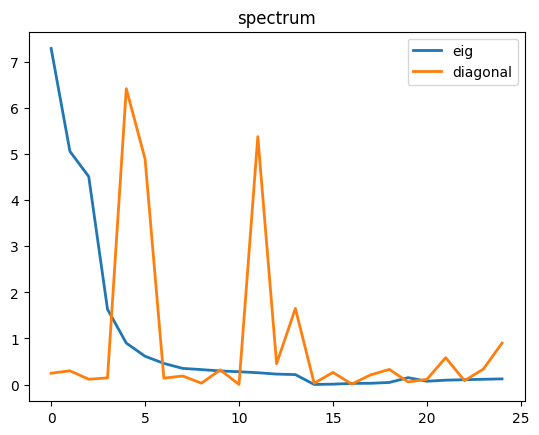

Test mean squared error after transformation: 4.533844811315841
Simulation: 1
Test mean squared error before transformation: 4.60627687936716


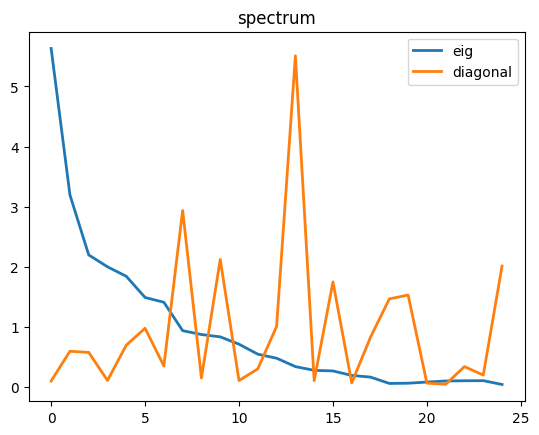

Test mean squared error after transformation: 4.66435040190305
Simulation: 2
Test mean squared error before transformation: 4.62259777039406


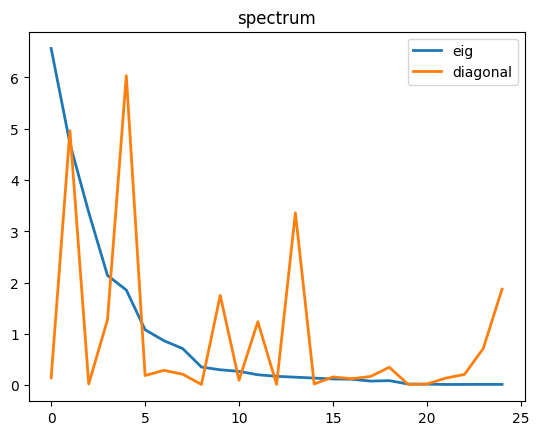

Test mean squared error after transformation: 4.570953032161953
Simulation: 3
Test mean squared error before transformation: 4.606589214757516


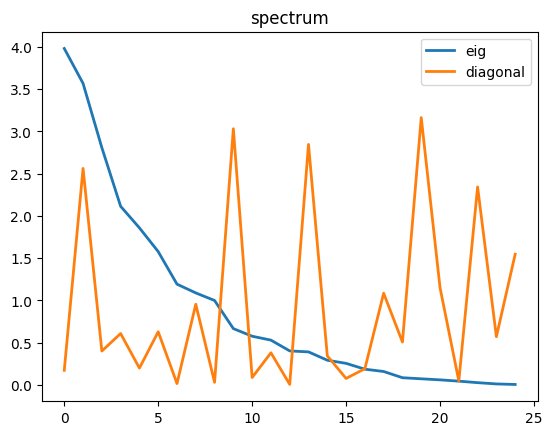

Test mean squared error after transformation: 4.571724200974106
Simulation: 4
Test mean squared error before transformation: 4.584007211943437


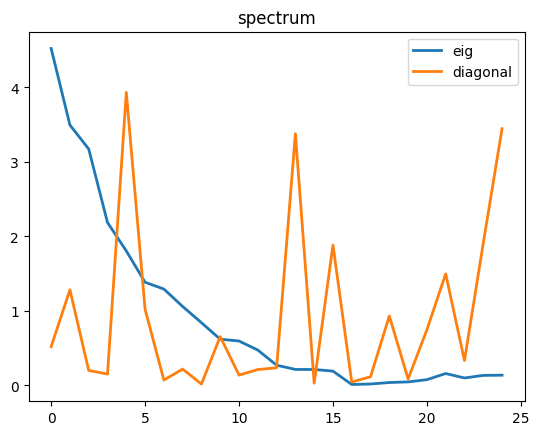

Test mean squared error after transformation: 4.553848786584132
number of training samples: 1000
Simulation: 0
Test mean squared error before transformation: 4.44391973254729


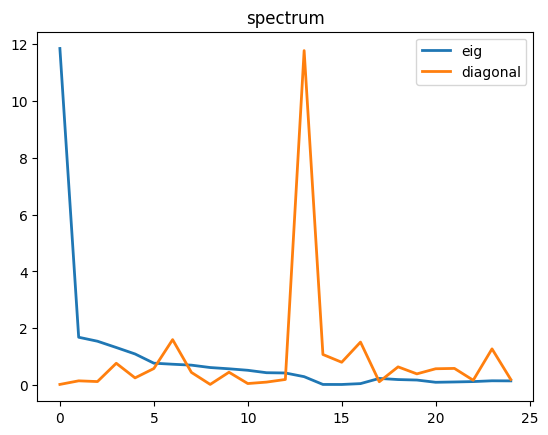

Test mean squared error after transformation: 4.450307105551194
Simulation: 1
Test mean squared error before transformation: 4.451563412088776


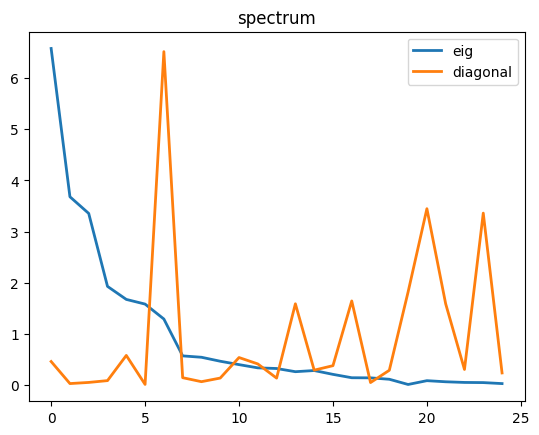

Test mean squared error after transformation: 4.437002441933793
Simulation: 2
Test mean squared error before transformation: 4.446892079207551


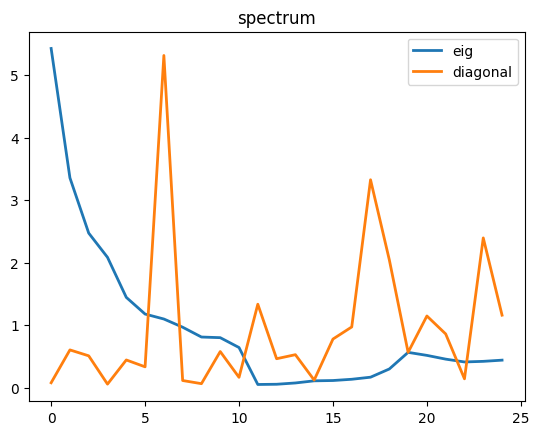

Test mean squared error after transformation: 4.432392983517145
Simulation: 3
Test mean squared error before transformation: 4.441954074274174


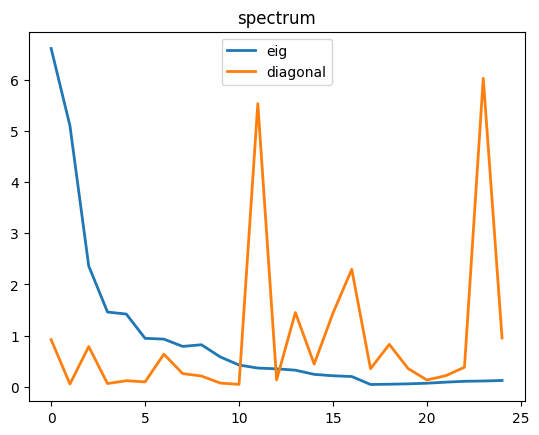

Test mean squared error after transformation: 4.428211090656971
Simulation: 4
Test mean squared error before transformation: 4.4428225324363835


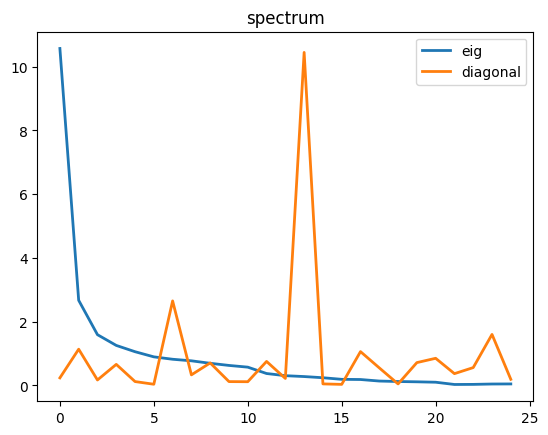

Test mean squared error after transformation: 4.467914576149991
number of training samples: 2500
Simulation: 0
Test mean squared error before transformation: 4.439276177457493


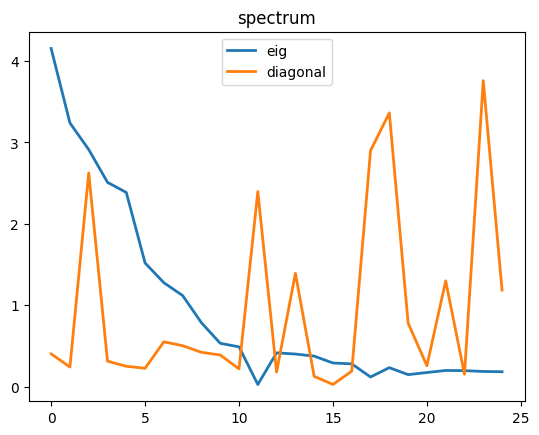

Test mean squared error after transformation: 4.443832715913703
Simulation: 1
Test mean squared error before transformation: 4.441216671354486


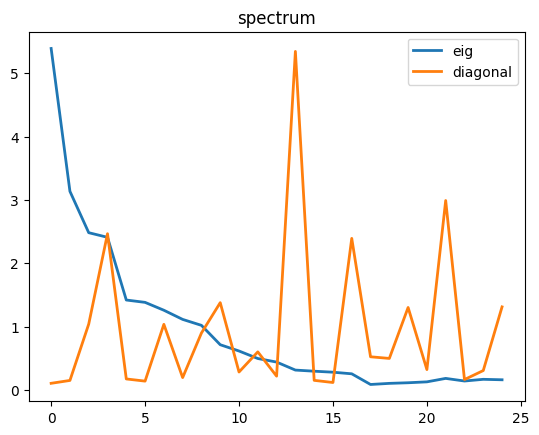

Test mean squared error after transformation: 4.424833247605864
Simulation: 2
Test mean squared error before transformation: 4.445845635533505


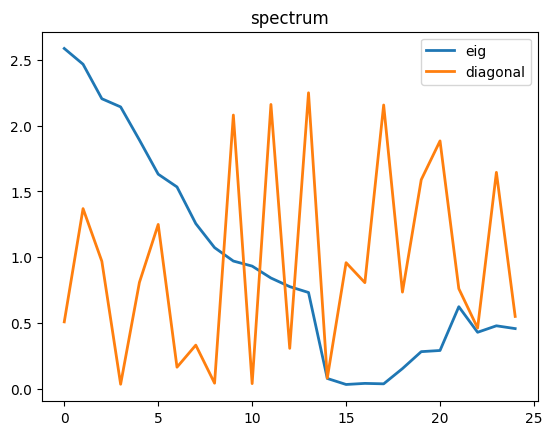

Test mean squared error after transformation: 4.420479604050662
Simulation: 3
Test mean squared error before transformation: 4.444677921639412


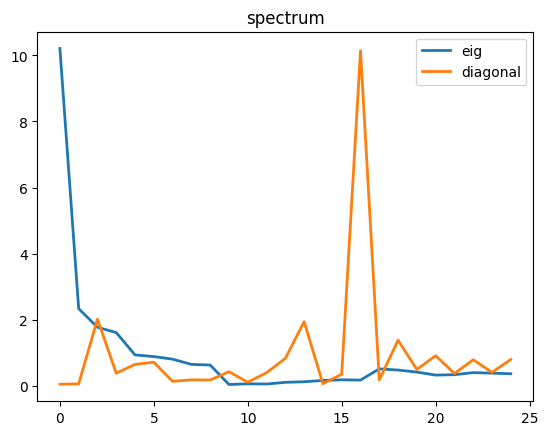

Test mean squared error after transformation: 4.4236181932680365
Simulation: 4
Test mean squared error before transformation: 4.446585424355909


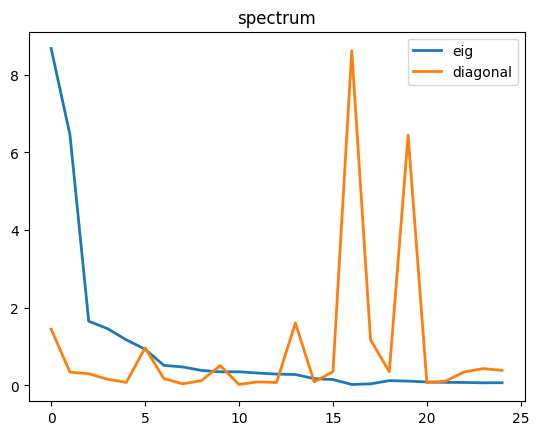

Test mean squared error after transformation: 4.444374967253686
number of training samples: 5000
Simulation: 0
Test mean squared error before transformation: 4.435513422764064


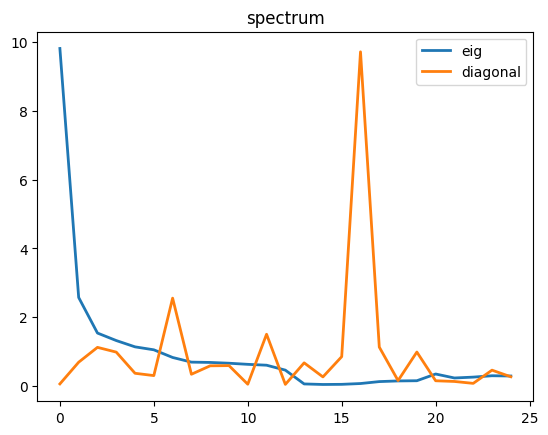

Test mean squared error after transformation: 4.432654869802718
Simulation: 1
Test mean squared error before transformation: 4.442250635270911


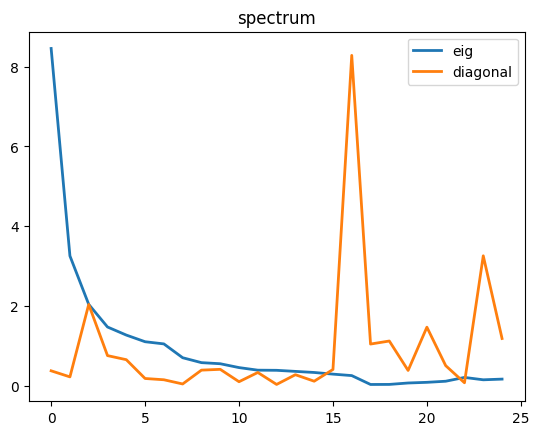

Test mean squared error after transformation: 4.419038573785257
Simulation: 2
Test mean squared error before transformation: 4.4412395341851605


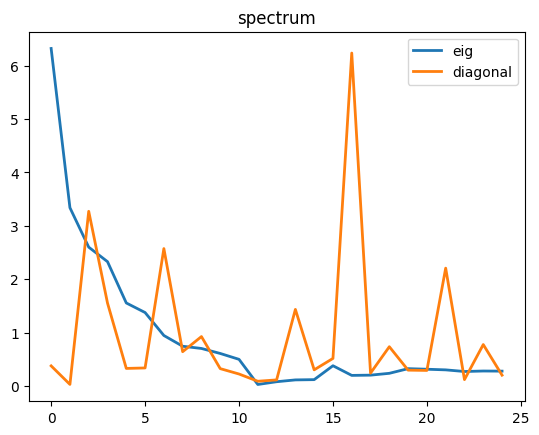

Test mean squared error after transformation: 4.429790365887142
Simulation: 3
Test mean squared error before transformation: 4.437369660154436


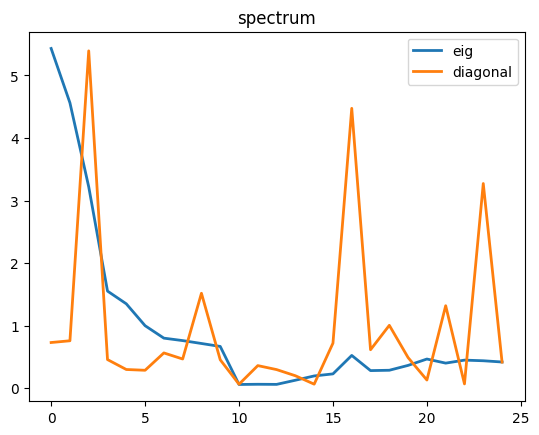

Test mean squared error after transformation: 4.422389595225279
Simulation: 4
Test mean squared error before transformation: 4.4394600669286035


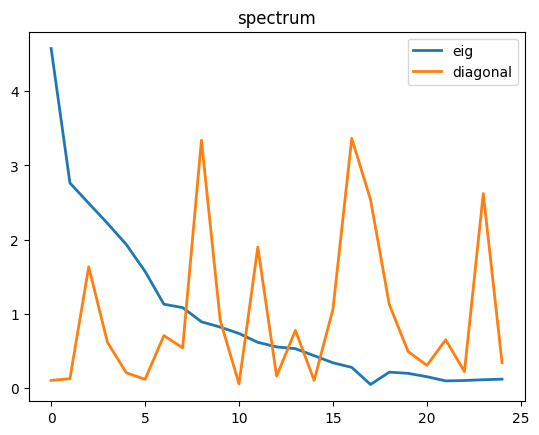

Test mean squared error after transformation: 4.4355100014800355
number of training samples: 7500
Simulation: 0
Test mean squared error before transformation: 4.442703037377704


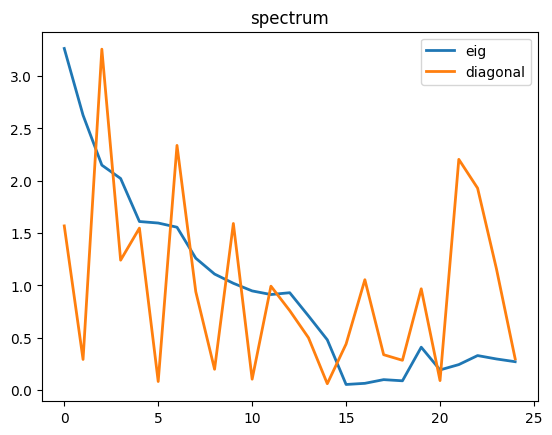

Test mean squared error after transformation: 4.427625006031197
Simulation: 1
Test mean squared error before transformation: 4.4405816856979055


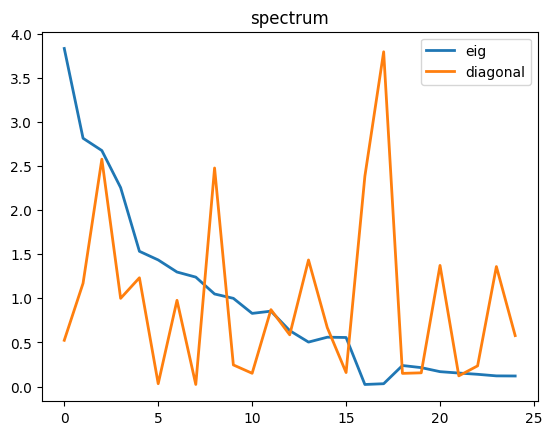

Test mean squared error after transformation: 4.431639103212731
Simulation: 2
Test mean squared error before transformation: 4.4438818912549385


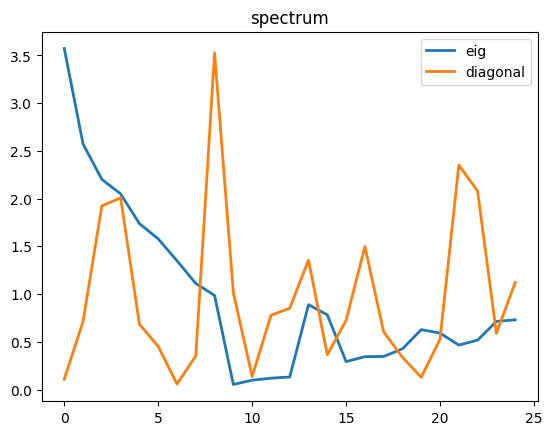

Test mean squared error after transformation: 4.438138235034379
Simulation: 3
Test mean squared error before transformation: 4.437752428827523


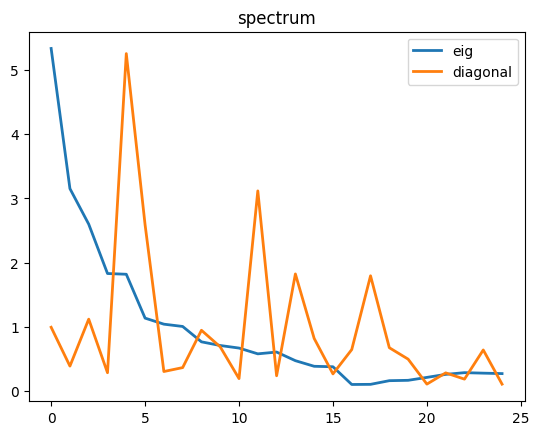

Test mean squared error after transformation: 4.432547707956693
Simulation: 4
Test mean squared error before transformation: 4.43954303498816


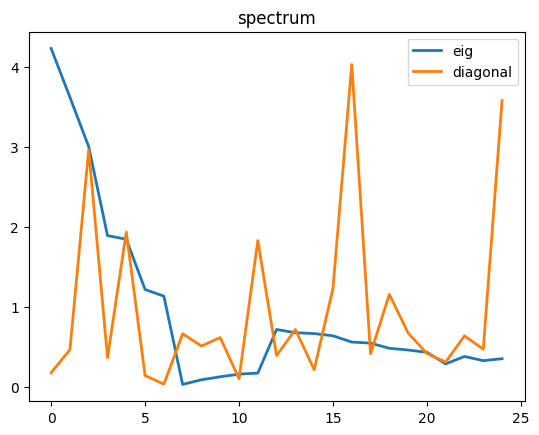

Test mean squared error after transformation: 4.43096681629793
number of training samples: 10000
Simulation: 0
Test mean squared error before transformation: 4.4365773446506545


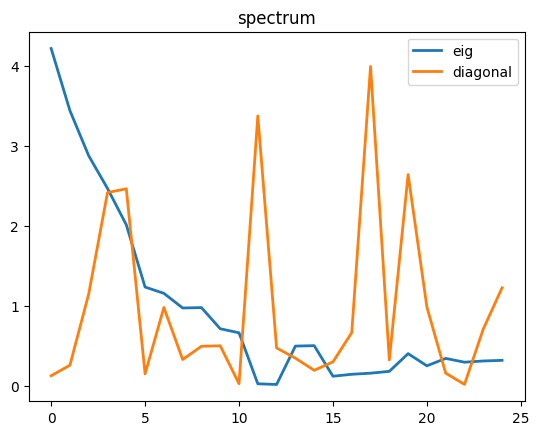

Test mean squared error after transformation: 4.438004792024363
Simulation: 1
Test mean squared error before transformation: 4.442160425808048


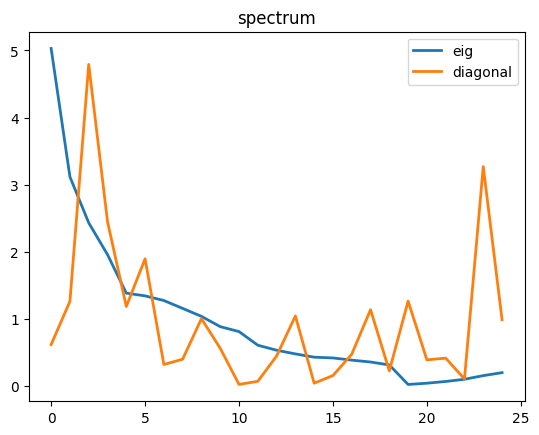

Test mean squared error after transformation: 4.430187657320986
Simulation: 2
Test mean squared error before transformation: 4.436155728658787


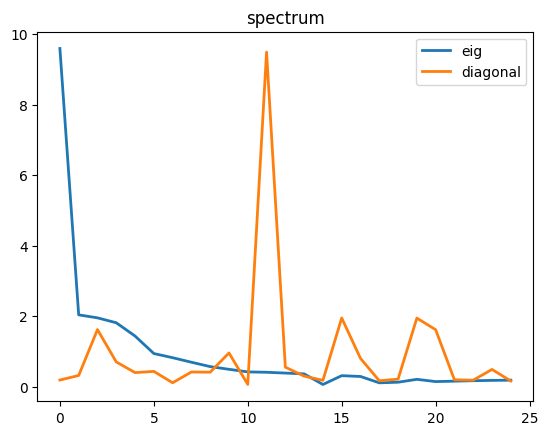

Test mean squared error after transformation: 4.413817135554888
Simulation: 3
Test mean squared error before transformation: 4.445201040210195


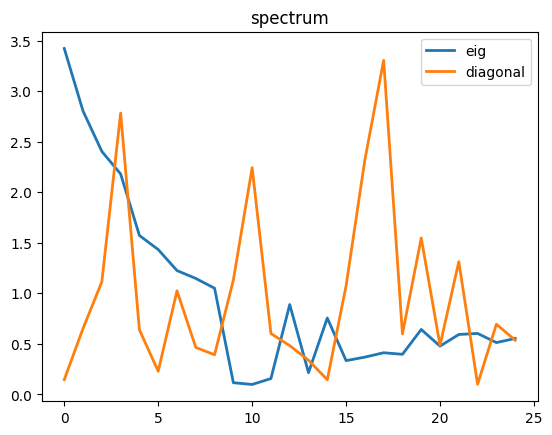

Test mean squared error after transformation: 4.434967440725758
Simulation: 4
Test mean squared error before transformation: 4.440310067100315


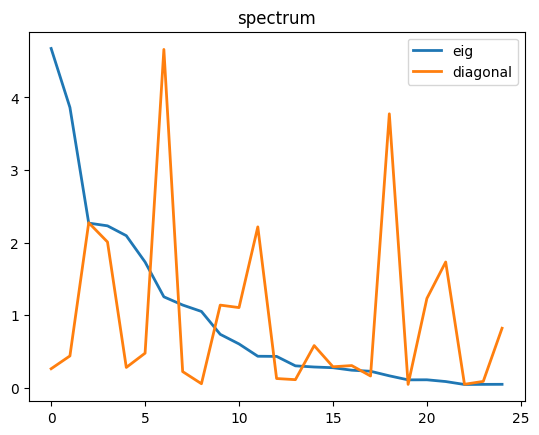

Test mean squared error after transformation: 4.43136918183207
number of training samples: 15000
Simulation: 0
Test mean squared error before transformation: 4.441260268220465


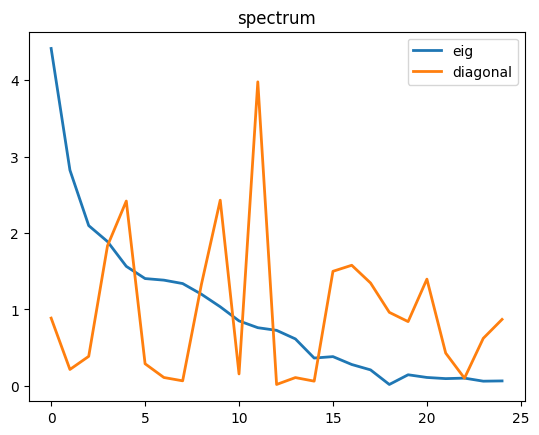

Test mean squared error after transformation: 4.434300941661555
Simulation: 1
Test mean squared error before transformation: 4.446556591175645


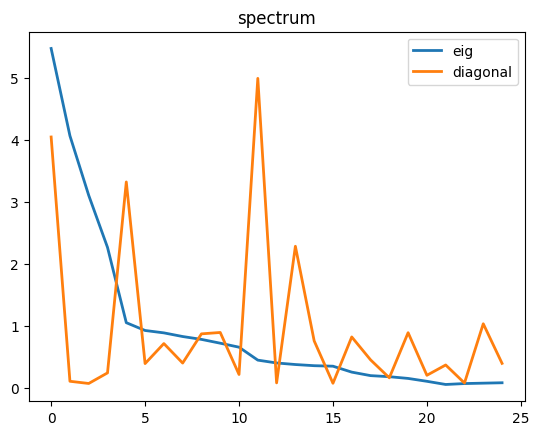

Test mean squared error after transformation: 4.446614325497976
Simulation: 2
Test mean squared error before transformation: 4.4387375280889625


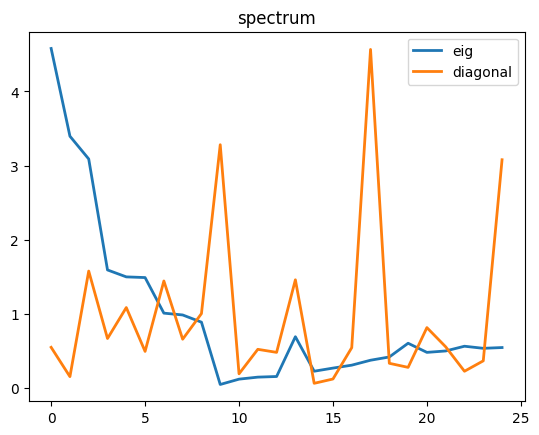

Test mean squared error after transformation: 4.432854492331445
Simulation: 3
Test mean squared error before transformation: 4.437979787504026


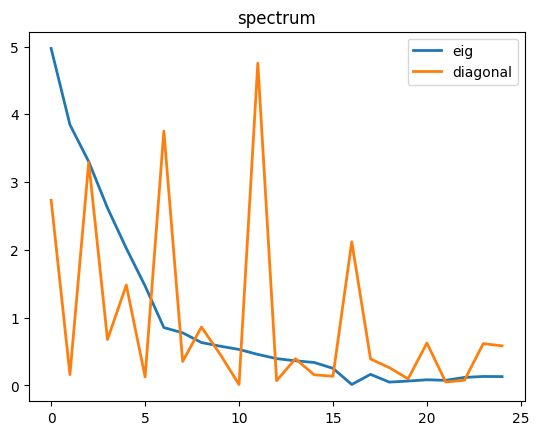

Test mean squared error after transformation: 4.430650785035526
Simulation: 4
Test mean squared error before transformation: 4.440570066578701


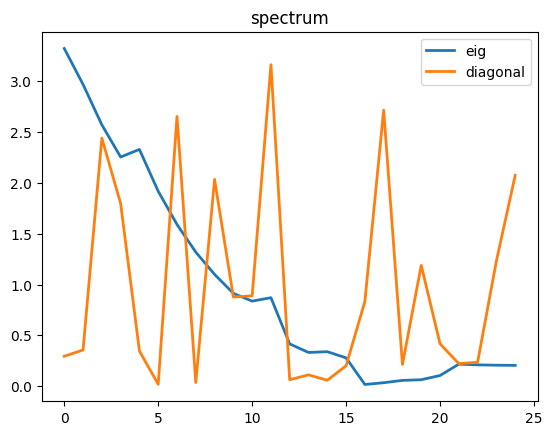

Test mean squared error after transformation: 4.420443190488179
number of training samples: 20000
Simulation: 0
Test mean squared error before transformation: 4.439700376192126


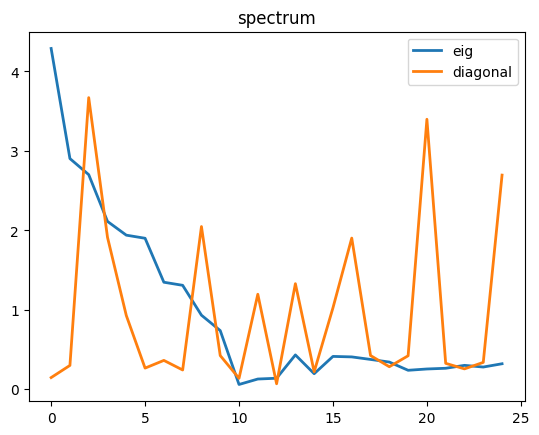

Test mean squared error after transformation: 4.422659120158403
Simulation: 1
Test mean squared error before transformation: 4.443405234982442


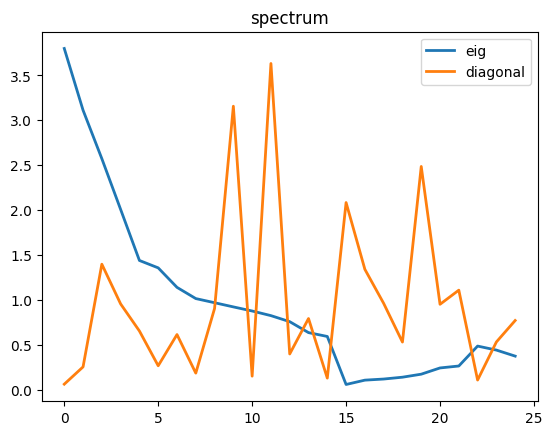

Test mean squared error after transformation: 4.41630664171896
Simulation: 2
Test mean squared error before transformation: 4.43815210840882


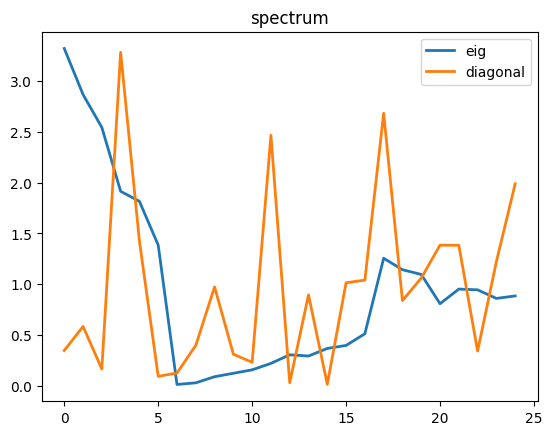

Test mean squared error after transformation: 4.432038667607873
Simulation: 3
Test mean squared error before transformation: 4.440237285203938


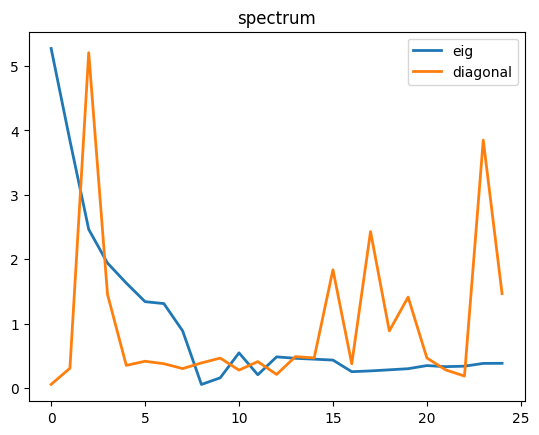

Test mean squared error after transformation: 4.435585286415843
Simulation: 4
Test mean squared error before transformation: 4.438573332117204


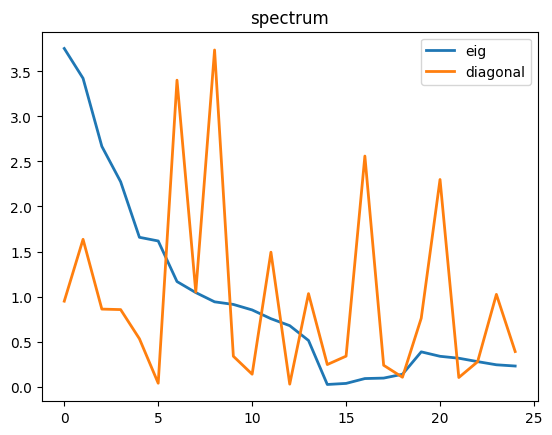

Test mean squared error after transformation: 4.436315953322871


In [3]:
stats = []

for n_sim in sample_range:
    print(f"number of training samples: {n_sim}")
    mse = {'n': n_sim, 'before': [], "after": []}
    for round in range(5):
        print(f"Simulation: {round}")
        mse_before, mse_after = simulate(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime_max, delta, weights_lifetime)
        mse['before'].append(mse_before)
        mse['after'].append(mse_after)
    stats.append(mse)

pickle.dump(stats, open("stat.pk", "wb"))

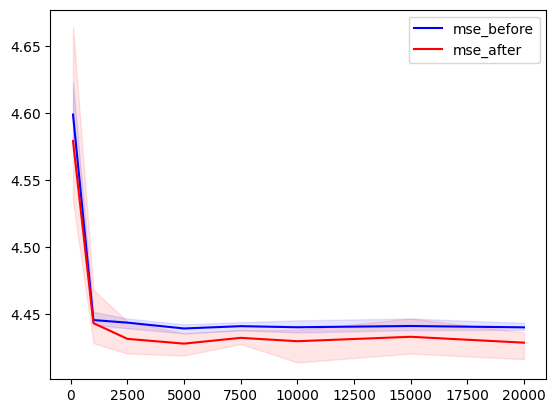

In [3]:
#stats = pickle.load(open("stat.pk", "rb"))
x = sample_range
before = []
before_min = []
before_max = []
after = []
after_min = []
after_max = []

for stat in stats:
    before.append(np.mean(stat['before']))
    before_min.append(np.min(stat['before']))
    before_max.append(np.max(stat['before']))
    after.append(np.mean(stat['after']))
    after_min.append(np.min(stat['after']))
    after_max.append(np.max(stat['after']))

fig, ax = plt.subplots()
ax.plot(x, before, color='b')
ax.plot(x, after, color='r')
ax.fill_between(x, (before_min), (before_max), color='b', alpha=.1)
ax.fill_between(x, (after_min), (after_max), color='r', alpha=.1)

plt.legend(["mse_before", "mse_after"], loc ="upper right")

In [5]:
from src.Mondrian_matrix_utils import simulate_proj

stats_best = {}
best = {}

for multiplier in range(1,3):
    print(f"lifetime multiplier: {multiplier}")
    stats_best[multiplier] = []
    best[multiplier] = {"mean": [], "min": [], "max": []}
    for n_sim in sample_range:
        stats_temp = []
        print(f"number of training samples: {n_sim}")
        mse = {'n': n_sim, 'best': []}
        for round in range(5):
            print(f"Simulation: {round}")
            mse_best = simulate_proj(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime_max * (multiplier), delta, weights_lifetime, rotation = rotation)
            mse['best'].append(mse_best)
            print(mse_best)
        stats_best[multiplier].append(mse)
        best[multiplier]["mean"].append(np.mean(mse['best']))
        best[multiplier]["min"].append(np.min(mse['best']))
        best[multiplier]["max"].append(np.max(mse['best']))

pickle.dump(stats_best, open("stats_proj.pk", "wb"))

lifetime multiplier: 1
number of training samples: 100
Simulation: 0
4.0745980308123
Simulation: 1
4.051209304435357
Simulation: 2
4.125077906051703
Simulation: 3
4.082521429911896
Simulation: 4
4.067140466935079
number of training samples: 1000
Simulation: 0
4.040505232958793
Simulation: 1
4.069142325982861
Simulation: 2
4.071874950519649
Simulation: 3
4.072759169150221
Simulation: 4
4.072530420722978
number of training samples: 2500
Simulation: 0
4.0835220825386855
Simulation: 1
4.100294239317527
Simulation: 2
4.062979009252142
Simulation: 3
4.084343375065866
Simulation: 4
4.099656008650746
number of training samples: 5000
Simulation: 0
4.1321152287470655
Simulation: 1
4.097623210518568
Simulation: 2
4.118308451174479
Simulation: 3
4.1098894300606466
Simulation: 4
4.101700087855573
number of training samples: 7500
Simulation: 0
4.106997619802654
Simulation: 1
4.139981375632578
Simulation: 2
4.113728371038688
Simulation: 3
4.121292854900514
Simulation: 4
4.106863006392895
number of tr

In [8]:
#from src.Mondrian_matrix_utils import simulate_proj
#best = {}

#for multiplier in range(1,3):
#    print(f"lifetime multiplier: {multiplier}")
#    best[multiplier] = {"mean": [], "min": [], "max": []}
#    for mse in stats_best[multiplier]:
#        best[multiplier]["mean"].append(np.mean(mse['best']))
#        best[multiplier]["min"].append(np.min(mse['best']))
#        best[multiplier]["max"].append(np.max(mse['best']))

lifetime multiplier: 1
lifetime multiplier: 2


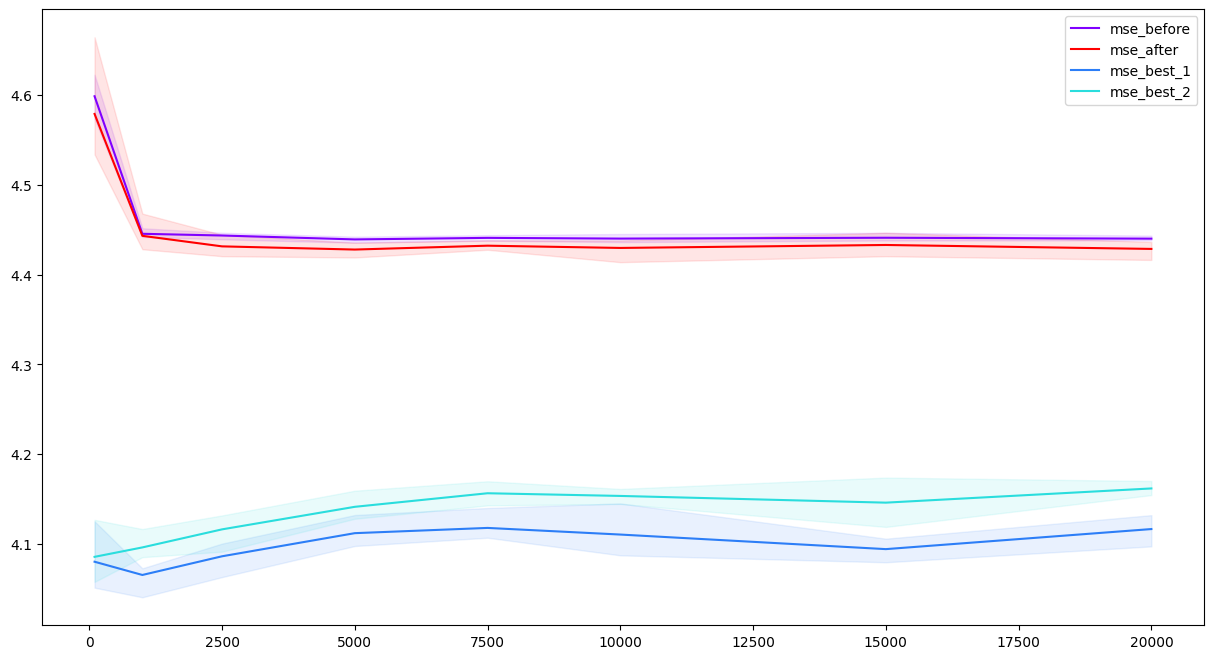

In [9]:
stats_best = pickle.load(open("stats_proj.pk", "rb"))
colors = plt.cm.rainbow(np.linspace(0, 1, 7))

fig, ax = plt.subplots(figsize=(15,8))

ax.plot(x, before, color=colors[0])
ax.plot(x, after, color=colors[6])
for multiplier in range(1,3):
    ax.plot(x, best[multiplier]["mean"], color=colors[multiplier])
plt.legend(["mse_before", "mse_after", "mse_best_1", "mse_best_2"], loc ="upper right")
ax.fill_between(x, (before_min), (before_max), color=colors[0], alpha=.1)
ax.fill_between(x, (after_min), (after_max), color=colors[6], alpha=.1)
for multiplier in range(1,3):
    ax.fill_between(x, (best[multiplier]["min"]), (best[multiplier]["max"]), color=colors[multiplier], alpha=.1)